In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_it_name = "google/gemma-2-2b-it"
model_it = AutoModelForCausalLM.from_pretrained(model_it_name, device_map="cuda:0")
model_it.eval()

/home/furrutia/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm): Gemm

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_base_name = "google/gemma-2-2b"
model_base = AutoModelForCausalLM.from_pretrained(model_base_name, device_map="cuda:1")
model_base.train()

Loading checkpoint shards: 100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm): Gemm

In [3]:
mlp_it = model_it.model.layers[0].mlp
mlp_it_parameters = {
    name: param
    for name, param in mlp_it.named_parameters()
}

In [4]:
mlp_base = model_base.model.layers[0].mlp
mlp_base_parameters = {
    name: param
    for name, param in mlp_base.named_parameters()
}

In [5]:
mlp_it_parameters.keys()

dict_keys(['gate_proj.weight', 'up_proj.weight', 'down_proj.weight'])

In [6]:
param_name = "down_proj.weight"
common_gpu = "cuda:1"
dW = mlp_it_parameters[param_name].to(common_gpu)- mlp_base_parameters[param_name].to(common_gpu)
dW

tensor([[ 5.0586e-04, -1.4684e-04,  4.5552e-04,  ...,  4.6315e-04,
          5.9772e-04,  4.8981e-04],
        [ 1.4561e-04,  5.7714e-04, -4.0439e-04,  ...,  5.4814e-04,
          4.9119e-04, -3.1594e-04],
        [ 1.2752e-03,  1.9519e-04, -1.7282e-04,  ...,  1.2237e-04,
          1.7962e-04,  3.4015e-05],
        ...,
        [ 3.8818e-04,  3.3716e-04, -1.9398e-04,  ...,  3.8712e-04,
          8.1834e-04, -3.2367e-04],
        [ 1.1246e-04, -3.3293e-04,  1.0031e-04,  ...,  4.4614e-04,
          1.0804e-04, -7.1803e-04],
        [-1.1373e-03, -6.9686e-04,  7.8780e-04,  ...,  9.9339e-04,
         -7.4076e-04, -8.7144e-04]], device='cuda:1', grad_fn=<SubBackward0>)

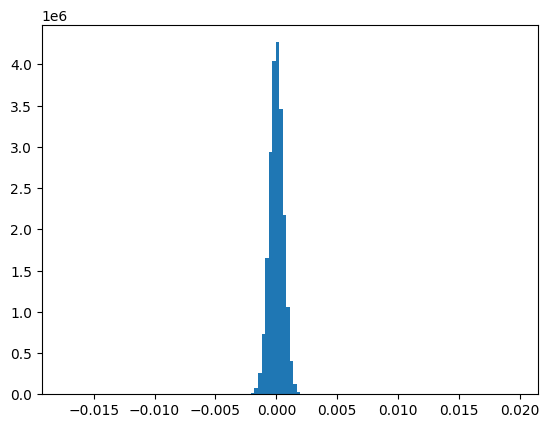

In [7]:
import matplotlib.pyplot as plt

plt.hist(dW.cpu().detach().numpy().ravel(), bins=128);

In [45]:
import torch
import torch.nn as nn
import torch.nn.init as init

class LowRankIO(nn.Module):
    def __init__(self, device, batch_size, hidden_size, rank, init_method='xavier'):
        super().__init__()
        self.device = device
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.rank = rank
        self.init_method = init_method

        # Define low-rank parameters
        self.A = nn.Parameter(torch.empty(batch_size, rank))
        self.B = nn.Parameter(torch.empty(rank, hidden_size))
        self.C = nn.Parameter(torch.empty(batch_size, rank))
        self.D = nn.Parameter(torch.empty(rank, hidden_size))

        self._initialize_parameters()

    def _initialize_parameters(self):
        if self.init_method == 'xavier':
            init.xavier_uniform_(self.A)
            init.xavier_uniform_(self.B)
            init.xavier_uniform_(self.C)
            init.xavier_uniform_(self.D)
        elif self.init_method == 'kaiming':
            init.kaiming_uniform_(self.A, a=5*.5)
            init.kaiming_uniform_(self.B, a=5*.5)
            init.kaiming_uniform_(self.C, a=5*.5)
            init.kaiming_uniform_(self.D, a=5*.5)
        elif self.init_method == 'normal':
            init.normal_(self.A, mean=0.0, std=0.02)
            init.normal_(self.B, mean=0.0, std=0.02)
            init.normal_(self.C, mean=0.0, std=0.02)
            init.normal_(self.D, mean=0.0, std=0.02)
        else:
            raise ValueError(f"Unsupported init_method: {self.init_method}")

    def forward(self):
        low_rank_input = self.A @ self.B       # shape: (batch_size, hidden_size)
        low_rank_output = self.C @ self.D      # shape: (batch_size, hidden_size)
        return low_rank_input.to(self.device), low_rank_output.to(self.device)


In [114]:
mlp_it_parameters.keys()

dict_keys(['gate_proj.weight', 'up_proj.weight', 'down_proj.weight'])

Grad stats: tensor(0.0002, device='cuda:1', grad_fn=<MedianBackward0>) tensor(0.0004, device='cuda:1', grad_fn=<MedianBackward0>)
Epoch 100/1000 | MSELoss (scaled): 0.316040 | CosSim: 0.2271 | Prop. Same Sign: 0.5591 | Outer Loss: 1.161973
Epoch 200/1000 | MSELoss (scaled): 0.314357 | CosSim: 0.2379 | Prop. Same Sign: 0.5634 | Outer Loss: 1.141760
Epoch 300/1000 | MSELoss (scaled): 0.313666 | CosSim: 0.2423 | Prop. Same Sign: 0.5648 | Outer Loss: 1.133898
Epoch 400/1000 | MSELoss (scaled): 0.313286 | CosSim: 0.2446 | Prop. Same Sign: 0.5656 | Outer Loss: 1.129648
Epoch 500/1000 | MSELoss (scaled): 0.313156 | CosSim: 0.2454 | Prop. Same Sign: 0.5660 | Outer Loss: 1.128053
Epoch 600/1000 | MSELoss (scaled): 0.313228 | CosSim: 0.2450 | Prop. Same Sign: 0.5661 | Outer Loss: 1.128635
Epoch 700/1000 | MSELoss (scaled): 0.312945 | CosSim: 0.2467 | Prop. Same Sign: 0.5665 | Outer Loss: 1.125617
Epoch 800/1000 | MSELoss (scaled): 0.312856 | CosSim: 0.2472 | Prop. Same Sign: 0.5667 | Outer Loss:

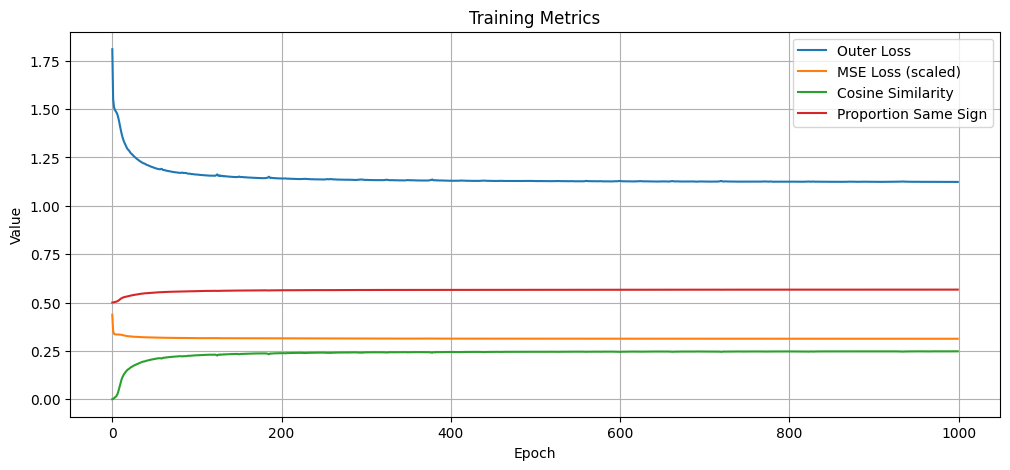

In [135]:
import torch
import torch.nn as nn
from torch.optim import AdamW
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
batch_size = 16
hidden_size = model_base.config.hidden_size
rank = 32
epochs = 1_000#10_000
gt_scaler = 1e6
loss_scaler = 1e6
learning_rate = 5e-3
init_method = "kaiming"

param_name = "gate_proj.weight"
common_gpu = "cuda:1"
dW = mlp_it_parameters[param_name].to(common_gpu)- mlp_base_parameters[param_name].to(common_gpu)

alpha = 3.0  # Weight for MSE
beta = 1.0   # Weight for (1 - CosineSim)
gamma = 1.0  # Weight for proportion of same sign

# Initialize I/O
low_rank_io = LowRankIO(common_gpu, batch_size, hidden_size, rank)
low_rank_input, low_rank_output = low_rank_io()

# Trainable parameters
trainable_parameters = low_rank_io.parameters()

# Optimizer
optimizer = torch.optim.AdamW(trainable_parameters, lr=learning_rate)

# Loss functions
inner_criterion = nn.SmoothL1Loss()
mse_criterion = nn.MSELoss()
target_param = mlp_base_parameters[param_name]

# Track losses and metrics
loss_history = []
mse_history = []
cos_sim_history = []
same_sign_history = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # Regenerate I/O
    low_rank_input, low_rank_output = low_rank_io()
    output = mlp_base(low_rank_input)

    # Compute inner loss
    inner_loss = inner_criterion(output, low_rank_output)

    # Compute gradient w.r.t. target_param
    grads = torch.autograd.grad(
        outputs=inner_loss,
        inputs=target_param,
        create_graph=True,
        retain_graph=True
    )[0]

    scaled_grads = gt_scaler * grads

    # Debug print for gradients stats on first epoch
    if epoch == 0:
        print("Grad stats:", scaled_grads.abs().median(), dW.abs().median())

    # Compute cosine similarity (clamped for numerical safety)
    cos_sim = torch.nn.functional.cosine_similarity(scaled_grads.flatten(), dW.flatten(), dim=0)
    cos_sim = torch.clamp(cos_sim, -1.0, 1.0)

    # Compute proportion of same sign elements
    proportion_same_sign = ((scaled_grads * dW) > 0).float().mean().item()

    # Compute scaled MSE loss
    mse_loss = loss_scaler * mse_criterion(scaled_grads, dW)

    # Hybrid outer loss
    outer_loss = alpha * mse_loss + beta * (1 - cos_sim) - gamma * proportion_same_sign

    # Backward + update
    outer_loss.backward()
    optimizer.step()

    # Log losses
    loss_history.append(outer_loss.item())
    mse_history.append(mse_loss.item())
    cos_sim_history.append(cos_sim.item())
    same_sign_history.append(proportion_same_sign)

    # Print progress every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} | "
              f"MSELoss (scaled): {mse_loss.item():.6f} | "
              f"CosSim: {cos_sim.item():.4f} | "
              f"Prop. Same Sign: {proportion_same_sign:.4f} | "
              f"Outer Loss: {outer_loss.item():.6f}")

# Plotting all metrics
plt.figure(figsize=(12, 5))
plt.plot(loss_history, label='Outer Loss')
plt.plot(mse_history, label='MSE Loss (scaled)')
plt.plot(cos_sim_history, label='Cosine Similarity')
plt.plot(same_sign_history, label='Proportion Same Sign')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics')
plt.legend()
plt.grid(True)
plt.show()